In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import sys
import matplotlib.pyplot as plt
import yaml
import cv2
from scipy.spatial.transform import Rotation
from scipy.signal import savgol_filter, medfilt
from scipy.ndimage import uniform_filter
from matplotlib.patches import Rectangle
from scipy.fft import fft, fftfreq

sys.path.append('/home/schiavazza/code/hpe/hpe-core/datasets/')

from vicon_processing.src.projection import ProjectionHelper
from vicon_processing.src.data_helpers import DvsLabeler, DvsHelper, C3dHelper
from vicon_processing.src import vis_utils, utils

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# load c3d vicon data
c3d_file_path = '/home/schiavazza/data/hpe/vicon_dataset/processed/arren/box_f1.c3d'
c3d_helper = C3dHelper(c3d_file_path, delay=0.2452674339662075)
print(c3d_helper.reader.point_labels)

/home/schiavazza/.local/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')


KeyboardInterrupt: 

In [ ]:
labels = [
    'camera:cam_right',
    'camera:cam_left',
    'camera:cam_back'
]

In [ ]:
c3d_helper.reader.frame_count

1637

In [ ]:
vicon_points = c3d_helper.get_vicon_points(range(1, c3d_helper.reader.frame_count), labels)

In [ ]:
labels = [
    'camera:cam_back',
    'camera:cam_right',
    'camera:cam_left'
    ]
vicon_points = c3d_helper.get_vicon_points(range(1, c3d_helper.reader.frame_count), labels)

camera_right = []
camera_left = []
camera_back = []
for f in vicon_points['points']:
    camera_right.append(f['camera:cam_right'][:3])
    camera_left.append(f['camera:cam_left'][:3])
    camera_back.append(f['camera:cam_back'][:3])

camera_right = np.array(camera_right)
camera_left = np.array(camera_left)
camera_back = np.array(camera_back)

In [ ]:
points = c3d_helper.points_dict_to_array(vicon_points)
points.shape

(4908, 4)

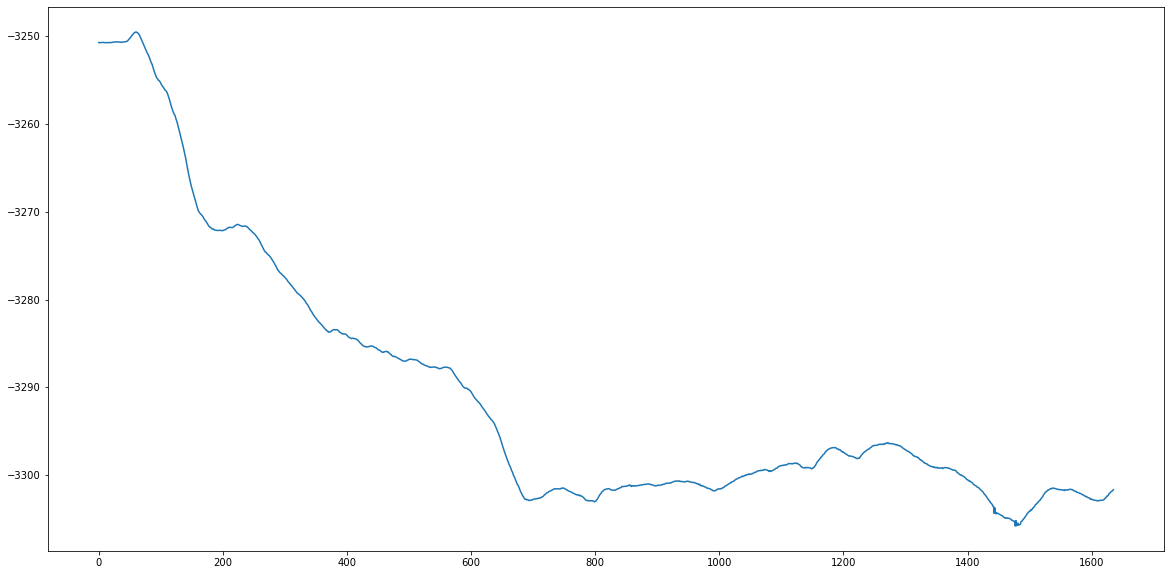

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(points[0::3, 0])

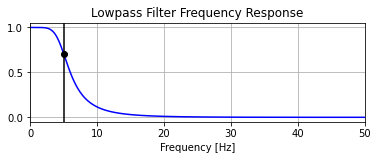

In [ ]:
import numpy as np
from scipy.signal import butter, lfilter, freqz, filtfilt
import matplotlib.pyplot as plt


def butter_lowpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def filter_dims(data, cutoff, fs, order=5):
    r = np.zeros_like(data)
    for i in range(data.shape[-1]):
        r[:, i] = butter_lowpass_filter(data[:, i], cutoff, fs, order)

    return r


# Filter requirements.
order = 3
fs = 100.0       # sample rate, Hz
cutoff = 5  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)

# Plot the frequency response.
w, h = freqz(b, a, fs=fs)
plt.subplot(2, 1, 1)
plt.plot(w, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()

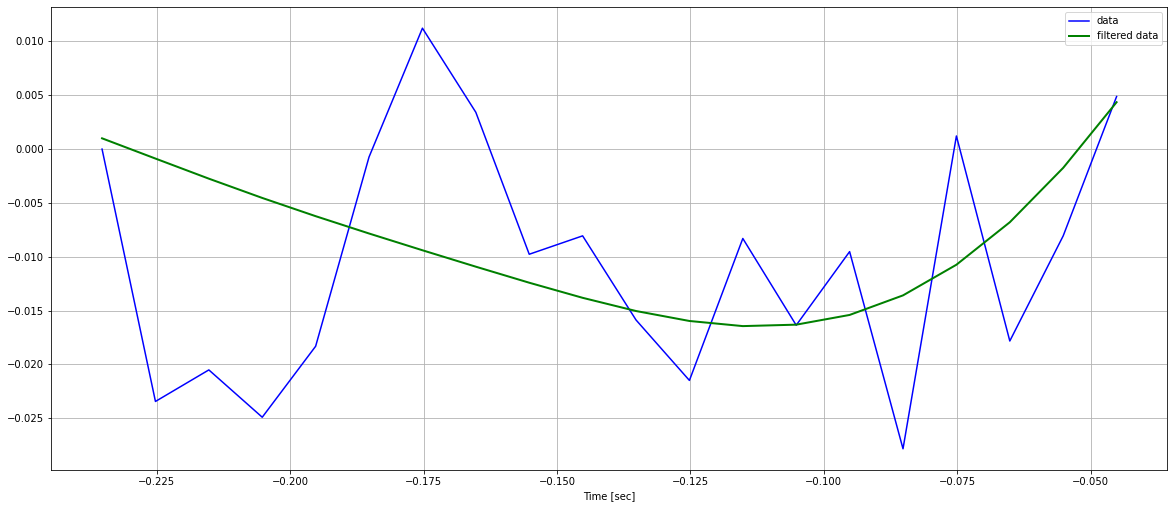

In [ ]:

# Demonstrate the use of the filter.
# First make some data to be filtered.
T = 15.0         # seconds
n = c3d_helper.reader.frame_count # total number of samples
t = c3d_helper.frame_times[1:]
# "Noisy" data.  We want to recover the 1.2 Hz signal from this.
data = points[::3, 0]
data -= data[0]

# Filter the data, and plot both the original and filtered signals.
y = butter_lowpass_filter(data, cutoff, fs, order)
s = 20
plt.figure(figsize=(20, 20))
plt.subplot(2, 1, 2)
plt.plot(t[:s], data[:s], 'b-', label='data')
plt.plot(t[:s], y[:s], 'g-', linewidth=2, label='filtered data')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

plt.subplots_adjust(hspace=0.35)
plt.show()

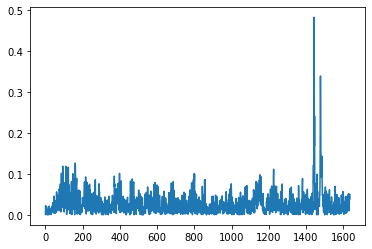

In [ ]:
plt.plot(np.abs(data - y))

In [ ]:
data.shape

(1636,)

In [ ]:
np.mean(np.abs(data - y))

0.029264062375926447

In [ ]:
back_diff = np.linalg.norm(np.diff(camera_back, axis=0), axis=-1)
right_diff = np.linalg.norm(np.diff(camera_right, axis=0), axis=-1)
left_diff = np.linalg.norm(np.diff(camera_left, axis=0), axis=-1)

In [ ]:
left_diff_filt = filter_dims(camera_left, cutoff, fs, order)

In [ ]:
left_diff_2 = np.linalg.norm(np.diff(left_diff_filt, axis=0), axis=-1)

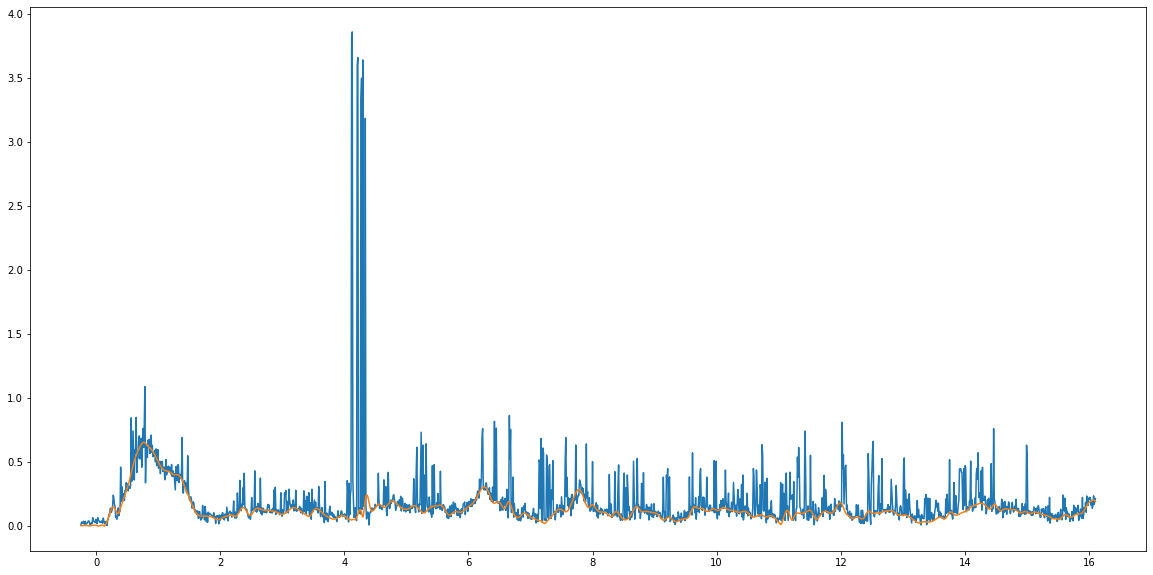

In [ ]:
times = c3d_helper.frame_times[:-2]
plt.figure(figsize=(20, 10))
# plt.plot(times, back_diff[:])
# plt.plot(times, right_diff[:])
plt.plot(times, left_diff[:])
plt.plot(times, left_diff_2[:])


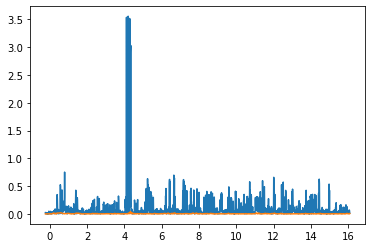

In [ ]:
plt.plot(times[:-1], np.abs(np.diff(left_diff[:])))
plt.plot(times[:-1], np.abs(np.diff(left_diff_2[:])))